In [1]:
%matplotlib inline
#import notebook
#from notebook.nbextensions import enable_nbextension
#enable_nbextension('notebook', 'usability/codefolding/main')
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
import pandas as pd
import sys
#sys.path.append('/Users/vs/Dropbox/Python')
from astropy.time import Time
import glob
import itertools
import gloess_fits as gf
import os
import re
from astropy.time import Time
import make_lightcurves_from_idl as idl_lc



bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

//anaconda/envs/astroconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Galactic Calibrator Light Curves
---

* Photometry has been done in IDL using the S19.2 location and pixel phase corrections
* Used a 3 pixel aperture, 3-7 pixel sky annulus.
* Location corrections were done using the irac_aphot_corr.pro script, at the same time as the pixel phase corrections
* Aperture corrections will be done here -- using the values provided by the SSC in June 2016.
* Adapted the photo_for_star2.pro script that we used for the Galactic Cepheids to use the new corrections. 

In [3]:
### Read in the RRL info file

directory = "/Users/vs/Dropbox/CRRP/RR_Lyrae_lightcurves/S19p2_reduction"
os.chdir(directory)

info_df = pd.read_csv('rrl_periods', delim_whitespace=True, header=None, names=['Name', 'Period', 'Type'])
info_df['Name_Lower'] = map(str.lower, info_df.Name)
info_df

,Name,Period,Type,Name_Lower
0,ABUma,0.599577,ab,abuma
1,AMTuc,0.405789,c,amtuc
2,ANSer,0.522069,ab,anser
3,APSer,0.340789,c,apser
4,AVPeg,0.390380,ab,avpeg
5,BHPeg,0.640983,ab,bhpeg
6,BXLeo,0.362772,c,bxleo
7,CSEri,0.311333,c,cseri
8,CUCom,0.405761,d,cucom
9,DHPeg,0.255510,c,dhpeg


In [4]:
unique_names = info_df.Name.unique()
len(unique_names)

51

51 unique IDs in the info_df dataframe

In [5]:
### Get an array containing the file names

filenames = glob.glob('*_phot')
mashed_names = []
for name in np.arange(len(filenames)):
    mashed_names.append(re.sub('_phot', '', filenames[name]))
    mashed_names[name] = re.sub('_', '', mashed_names[name])
filenames_df = pd.DataFrame(filenames)
mashednames_df = pd.DataFrame(map(str.lower, mashed_names))
names_df = pd.concat([filenames_df, mashednames_df], 1)
names_df.columns = ['Filename', 'Name_Lower']

In [6]:
rrl_df = info_df.merge(names_df, on='Name_Lower')

In [7]:
rrl_df

,Name,Period,Type,Name_Lower,Filename
0,ABUma,0.599577,ab,abuma,AB_Uma_phot
1,AMTuc,0.405789,c,amtuc,AM_Tuc_phot
2,ANSer,0.522069,ab,anser,AN_Ser_phot
3,APSer,0.340789,c,apser,AP_Ser_phot
4,AVPeg,0.390380,ab,avpeg,AV_Peg_phot
5,BHPeg,0.640983,ab,bhpeg,BH_Peg_phot
6,BXLeo,0.362772,c,bxleo,BX_Leo_phot
7,CSEri,0.311333,c,cseri,CS_Eri_phot
8,CUCom,0.405761,d,cucom,CU_Com_phot
9,DHPeg,0.255510,c,dhpeg,DH_Peg_phot


OK - Now we can make some light curves and do some gloess fitting. Test on one to start with


Aperture corrections and zero-points
---
Aperture corrections and zero-points are as given by the SSC at the end of June 2016. These are the final values. Location correction and pixel phase correction were done in IDL (in the irac_apcor_phot script) and do not need to be applied here.
* [3.6]: zp = 280.9, apcor = 1.125
* [4.5]: zp = 179.7, apcor = 1.123

In [8]:
zp36 = 280.9
zp45 = 179.7
apcor36 = 1.125
apcor45 = 1.123

0
0
0
0
0
0
ch2 21 [ 8.2377348   8.23746711] [ 0.00011  0.00012] 0.000927370666997
ch2 21 [ 8.2377348   8.23746711] [ 0.00011  0.00012] 0.000927370666997
0


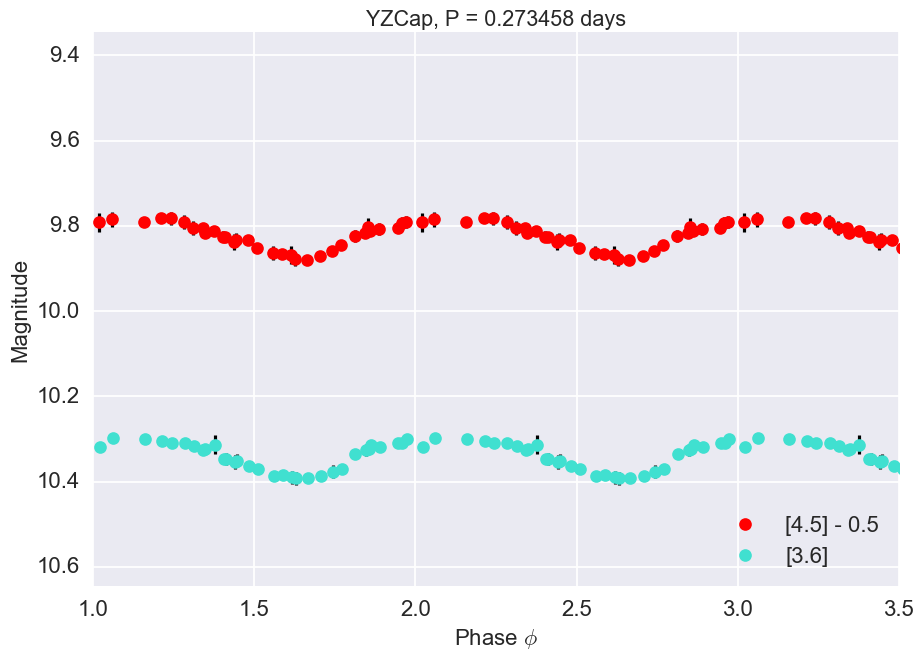

In [9]:
for rrl in np.arange(len(rrl_df)):
    idl_lc.make_lightcurve(rrl_df.Filename[rrl], rrl_df.Period[rrl], apcor1=apcor36, apcor2=apcor45, zp1=zp36, zp2=zp45)
    

In [10]:
filename = rrl_df.Filename[0]

In [11]:
data_df = pd.read_csv(filename, delim_whitespace=True, header=None, names=('Channel', 'MJD', 'flux', 'eflux', 'bigflux'))

In [12]:
data_df

,Channel,MJD,flux,eflux,bigflux
0,1,56515.44746,0.03711,0.00009,0.04219
1,1,56515.44759,0.03720,0.00009,0.04146
2,1,56515.44773,0.03724,0.00009,0.04198
3,1,56515.44786,0.03707,0.00009,0.04376
4,1,56515.44800,0.03699,0.00009,0.04204
5,1,56515.41985,0.03723,0.00009,0.04281
6,1,56515.41997,0.03755,0.00009,0.04190
7,1,56515.42011,0.03814,0.00009,0.04269
8,1,56515.42025,0.03771,0.00009,0.04374
9,1,56515.42039,0.03739,0.00009,0.04193


In [13]:
channel1_df = data_df[data_df.Channel==1]

In [14]:
sorted_ch1_df = channel1_df.sort_values(by='MJD')

In [15]:
sorted_ch1_df = sorted_ch1_df.reset_index(drop=True)
sorted_ch1_df

,Channel,MJD,flux,eflux,bigflux
0,1,56515.26132,0.03843,0.00009,0.04369
1,1,56515.26145,0.03806,0.00009,NaN
2,1,56515.26159,0.03825,0.00009,0.04330
3,1,56515.26173,0.03864,0.00009,0.04395
4,1,56515.26187,0.03834,0.00009,0.04327
5,1,56515.28608,0.03781,0.00009,0.04378
6,1,56515.28621,0.03816,0.00009,0.04341
7,1,56515.28635,0.03874,0.00009,0.04334
8,1,56515.28649,0.03852,0.00009,0.04389
9,1,56515.28662,0.03846,0.00009,0.04362


In [16]:
diffs = sorted_ch1_df.MJD[10:15]-sorted_ch1_df.MJD[10]

In [17]:
diffs

10    0.00000
11    0.00012
12    0.00027
13    0.00040
14    0.00054
Name: MJD, dtype: float64

In [18]:
ratio1 = diffs/diffs[1]
ratio2 = diffs/diffs[2]
ratio3 = diffs/diffs[3]
ratio4 = diffs/diffs[4]
ratio5 = diffs/diffs[5]

KeyError: 1

In [19]:
np.floor(ratio1), np.floor(ratio2), np.floor(ratio3), np.floor(ratio4), np.floor(ratio5)

NameError: name 'ratio1' is not defined

In [20]:
sorted_ch1_df['timebin'] = 0

In [21]:
sorted_ch1_df

,Channel,MJD,flux,eflux,bigflux,timebin
0,1,56515.26132,0.03843,0.00009,0.04369,0
1,1,56515.26145,0.03806,0.00009,NaN,0
2,1,56515.26159,0.03825,0.00009,0.04330,0
3,1,56515.26173,0.03864,0.00009,0.04395,0
4,1,56515.26187,0.03834,0.00009,0.04327,0
5,1,56515.28608,0.03781,0.00009,0.04378,0
6,1,56515.28621,0.03816,0.00009,0.04341,0
7,1,56515.28635,0.03874,0.00009,0.04334,0
8,1,56515.28649,0.03852,0.00009,0.04389,0
9,1,56515.28662,0.03846,0.00009,0.04362,0


In [22]:
np.arange(0, len(sorted_ch1_df), 5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160])

In [23]:
thistimebin = 0
obs=0
binwidth = 5
### imitating a do-while loop here
### run while datapoints remaining

datarem=True
med_diff = 0
#while (obs < (len(sorted_ch1_df))-1):
#for obs in np.arange(len(sorted_ch1_df)):
while datarem == True:
    old_diff = med_diff
    print 'start of loop' + str(obs)
    if (obs + binwidth > len(sorted_ch1_df)):
        diffs = sorted_ch1_df.MJD[obs:]-sorted_ch1_df.MJD[obs]
        diffs = diffs.reset_index(drop=True)
    else:
        diffs = sorted_ch1_df.MJD[obs:obs+binwidth]-sorted_ch1_df.MJD[obs]
        diffs = diffs.reset_index(drop=True)
    if len(diffs) > 1:
        ratio = diffs / diffs[1]
        for dither in np.arange(len(ratio)):
            if (np.floor(ratio[dither]) in np.arange(binwidth)):
                print obs, thistimebin, ratio[dither]
                sorted_ch1_df.ix[obs, 'timebin'] =  thistimebin
                obs = obs + 1
            else:
                break
    if(obs < len(sorted_ch1_df)): 
        datarem = True
    elif(obs == len(sorted_ch1_df)): 
        diffs = sorted_ch1_df.MJD[obs-1:]-sorted_ch1_df.MJD[obs-1]
        diffs = diffs.reset_index(drop=True)
        ratio = diffs / diffs[1]
        if (np.floor(ratio[1]) == 1.0):
            print obs, thistimebin, ratio[1]
            sorted_ch1_df.ix[obs, 'timebin'] =  thistimebin
        else:
            print obs, thistimebin, ratio[1]
            sorted_ch1_df.ix[obs, 'timebin'] =  thistimebin+1
            datarem = False
    else:
        datarem = False
    thistimebin = thistimebin + 1
    med_diff = np.median(diffs)
    print old_diff, med_diff
    if ((med_diff > 10*old_diff) and obs > 5):
        obs = obs - binwidth
        binwidth = binwidth - 1
        med_diff = old_diff
    if ((med_diff < 10*old_diff) and binwidth < 5):
        binwidth = 5
    if(binwidth == 0):
        break

start of loop0
0 0 0.0
1 0 1.0
2 0 2.07692310706
3 0 3.15384627009
4 0 4.23076943312
0 0.000269999989541
start of loop5
5 1 0.0
6 1 1.0
7 1 2.07692298651
8 1 3.15384597302
9 1 4.15384597302
0.000269999989541 0.000270000004093
start of loop10
10 2 0.0
11 2 1.0
12 2 2.25000010611
13 2 3.33333359608
14 2 4.50000033348
0.000270000004093 0.000269999989541
start of loop15
15 3 0.0
16 3 1.0
17 3 2.24999995453
18 3 3.41666655045
19 3 4.49999984842
0.000269999989541 0.000270000004093
start of loop20
20 4 0.0
21 4 1.0
22 4 1.00760456301
23 4 1.01711026643
24 4 1.02534854229
0.000270000004093 0.0158999999985
start of loop20
20 5 0.0
21 5 1.0
22 5 1.00760456301
23 5 1.01711026643
24 5 1.02534854229
0.000270000004093 0.0158999999985
start of loop20
20 6 0.0
21 6 1.0
22 6 1.00760456301
23 6 1.01711026643
24 6 1.02534854229
0.000270000004093 0.0158999999985
start of loop20
20 7 0.0
21 7 1.0
22 7 1.00760456301
23 7 1.01711026643
24 7 1.02534854229
0.000270000004093 0.0158999999985
start of loop20
20 8

KeyboardInterrupt: 

In [46]:
sorted_ch1_df

,Channel,MJD,flux,eflux,bigflux,timebin
0,1,56515.26132,0.03843,0.00009,0.04369,0
1,1,56515.26145,0.03806,0.00009,NaN,0
2,1,56515.26159,0.03825,0.00009,0.04330,0
3,1,56515.26173,0.03864,0.00009,0.04395,0
4,1,56515.26187,0.03834,0.00009,0.04327,0
5,1,56515.28608,0.03781,0.00009,0.04378,1
6,1,56515.28621,0.03816,0.00009,0.04341,1
7,1,56515.28635,0.03874,0.00009,0.04334,1
8,1,56515.28649,0.03852,0.00009,0.04389,1
9,1,56515.28662,0.03846,0.00009,0.04362,1


In [33]:
sorted_ch1_df.timebin

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
135    0
136    0
137    0
138    0
139    0
140    0
141    0
142    0
143    0
144    0
145    0
146    0
147    0
148    0
149    0
150    0
151    0
152    0
153    0
154    0
155    0
156    0
157    0
158    0
159    0
160    0
161    0
162    0
163    0
164    0
Name: timebin, dtype: int64

In [24]:
binwidth=5
np.arange(binwidth)

array([0, 1, 2, 3, 4])

In [25]:
    if (np.floor(ratio1[0]) == 0): ### First dither in set
        sorted_ch1_df.ix[sorted_ch1_df.timebin==obs, 'timebin'] = thistimebin
        obs = obs + 1
        if (np.floor(ratio1[1]) == 1): ### Second dither
            sorted_ch1_df.ix[sorted_ch1_df.timebin==obs, 'timebin'] = thistimebin
            obs = obs + 1
            if (np.floor(ratio1[2]) == 2): ### third dither
                sorted_ch1_df.ix[sorted_ch1_df.timebin==obs, 'timebin'] = thistimebin
                obs = obs + 1
                if (np.floor(ratio1[3]) == 3): ### fourth dither
                    sorted_ch1_df.ix[sorted_ch1_df.timebin==obs, 'timebin'] = thistimebin
                    obs = obs + 1
                    if (np.floor(ratio1[4]) == 4): ### final possible dither
                        sorted_ch1_df.ix[sorted_ch1_df.timebin==obs, 'timebin'] = thistimebin
                        obs = obs + 1
    print 'end of loop' + str(obs)
    thistimebin = thistimebin + 1
    


NameError: name 'ratio1' is not defined